# Mercedes tuned XGB model

This is based on the the initial template for XGB analysis of the data with additional PCA for features.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import time
import os

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [87]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prediction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

# Data preprocessing

In [ ]:
# load train and test data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

(train.shape, test.shape)
# encode categorical data
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
# get X and y for training
X_train = train.drop('y', axis=1)
y_train = train['y']

# get X for testing
X_test = test
X_train.shape, y_train.shape, X_test.shape

# Feature engineering

In [ ]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(X_train)
tsvd_results_test = tsvd.transform(X_test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(X_train)
pca2_results_test = pca.transform(X_test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(X_train)
ica2_results_test = ica.transform(X_test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(X_train)
grp_results_test = grp.transform(X_test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(X_train)
srp_results_test = srp.transform(X_test)

#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# create empty dataframes to capture extra features
extra_features_train = pd.DataFrame()
extra_features_test = pd.DataFrame()

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    extra_features_train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    extra_features_test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    extra_features_train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    extra_features_test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    extra_features_train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    extra_features_test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    extra_features_train['grp_' + str(i)] = grp_results_train[:, i - 1]
    extra_features_test['grp_' + str(i)] = grp_results_test[:, i - 1]

    extra_features_train['srp_' + str(i)] = srp_results_train[:, i - 1]
    extra_features_test['srp_' + str(i)] = srp_results_test[:, i - 1]

extra_features_train.shape, extra_features_test.shape

# Cross validation

# Stacked model

In [ ]:
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, 
                                                          max_features=0.55, min_samples_leaf=18, min_samples_split=14, 
                                                          subsample=0.7)),
    LassoLarsCV()
)

# stacked model is trained without the extra features
stacked_pipeline.fit(X_train, y_train)
y_pred1 = stacked_pipeline.predict(X_test)

In [74]:
# evaluate pipeline
# t0 = time.time()
# seed = 7
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(stacked_pipeline, X_train, y_train, cv=kfold)
# print(results.mean())
# print("Done: {:.1f} s".format(time.time() - t0))

# 0.575790611694
# Done: 47.7 s

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.882e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.882e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=8.904e-03, previous alpha=7.598e-03, with an active set 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.932e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=5.923e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.501e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.825e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.960e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.994e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.436e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.819e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=3.409e-03, with an active set of 46 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=3.409e-03, with an active set of 46 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.844e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=5.599e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=5.599e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.996e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.996e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.934e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.141e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=6.059e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.337e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.825e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.023e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.972e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.462e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.874e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.937e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=3.585e-03, with an active set of 41 regressors, and the smallest cholesky pivot element being 1.490e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=1.974e-03, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=1.974e-03, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=1.972e-03, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.107e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.076e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.822e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:37

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.965e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.068e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)


/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.676e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=6.064e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.343e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.054e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=2.423e-03, with an active set of 72 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=2.423e-03, with an active set of 72 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=2.355e-03, with an active set of 75 regressors, and the smallest cholesky pivot element being 1.490e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.016e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.687e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.687e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.903e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.891e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.403e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.390e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.757e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=6.349e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.258e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.085e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.017e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.709e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=1.642e-02, previous alpha=1.630e-02, with an active set of

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.967e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.160e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.857e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.500e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.170e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.170e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.602e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.177e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.849e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.754e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.383e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.598e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.430e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.271e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.645e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.645e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.870e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.096e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.749e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.049e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=5.352e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=4.006e-03, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.107e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.852e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.926e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.091e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.091e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.978e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.879e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.155e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.611e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08
 

0.575790611694
Done: 47.7 s


# XGB Model

In [96]:
X_train = np.hstack((X_train, extra_features_train))
X_test = np.hstack((X_test, extra_features_test))

In [119]:
# train XGB
print('Training')
t0 = time.time()
num_round = 1250
eta = 0.0045
param = {'n_trees': 520, 
         'max_depth':4, 
         'eta':eta, 'learning_rate':eta,
         'silent':1, 'objective':'reg:linear', 
         'subsample':0.93,# 'colsample_bytree':0.5, 
         'n_estimators':num_round, 'num_boost_round':num_round}
dtrain = xgb.DMatrix(data=X_train, label=y_train)
#watchlist  = [(dtest,'test'), (dtrain,'train')]
xgb_model = xgb.train(param, dtrain, num_round)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

Training


Done: 122.1 s


In [44]:
# evaluate pipeline
t0 = time.time()
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(xgb.XGBRegressor(**param), X_train, y_train, cv=kfold) # xgb_model in sklearn wrapper
print(results.mean())
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

# 0.573627668125 for xgb_model
# Done: 76.6 s

# 0.573665697336 # xgb_model2
# Done: 1384.7 s

0.573665697336
Done: 1384.7 s


# Cross validation

In [ ]:
def evalcoef(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# train XGB
print('Cross validating')
t0 = time.time()
# param same as for training
# dtrain = xgb.DMatrix(data=X_train, label=y_train)
# watchlist  = [(dtest,'test'), (dtrain,'train')]
num_folds = 10
xgb_modelcv = xgb.cv(param, dtrain, num_round, num_folds, feval=evalcoef)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

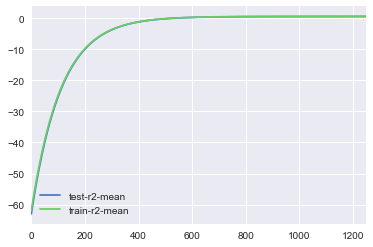

In [105]:
xgb_modelcv[['test-r2-mean', 'train-r2-mean']].plot()
#plt.xlim(400,500)

# Make test predictions

In [120]:
# get predictions from model
dtest = xgb.DMatrix(data=X_test)
y_pred2 = xgb_model.predict(dtest)

In [121]:
# average predictions from stacked model and xgb
y_pred = y_pred2*0.80 + y_pred1*0.20

In [122]:
# create submission csv file
dirname = 'output'
count = len(os.listdir(os.path.join(os.getcwd(), dirname))) + 1
filename = 'sub' + str(count) + '_xgb' + '_maxdepth' + str(param['max_depth']) + '_eta' + str(param['eta']) + \
           '_numround' + str(num_round) + '.csv'
pd.concat([test.ID, pd.Series(y_pred)], axis=1).to_csv(dirname + '/' + filename,
                                                       header=['ID', 'y'], index=False)